# Pre-processing of GLAMOS MB data:

## Setting up:

In [28]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import config
from cmcrameri import cm

from scripts.helpers import *
from scripts.glamos_preprocess import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_all(config.SEED)
custom_working_dir = '../../../data/OGGM/'

In [3]:
seed_all(config.SEED)

# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
vois_topographical = [
    "aspect", "slope", "dis_from_border", "hugonnet_dhdt",
    "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
    "millan_vy"
]
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

# For bars and lines:
# color_diff_xgb = '#878787'
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_xgb = colors[0]
color_xgb_winter = colors[1]

color_tim = '#c51b7d'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .6,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
    "showmeans": True,
    "meanprops": {
        "markerfacecolor": "white"
    }
}

marker_tim = 's'
marker_xgb = 'o'
marker_std = '_'

custom_working_dir = '../../../data/OGGM/'

## 1. Transform .dat files to .csv:

In [4]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_mb_a, glamosfiles_mb_w = [], []
for file in os.listdir(path_PMB_GLAMOS_a_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_a_raw, file)):
        glamosfiles_mb_a.append(file)

for file in os.listdir(path_PMB_GLAMOS_w_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_w_raw, file)):
        glamosfiles_mb_w.append(file)

print('Examples of index stake raw files:\n', glamosfiles_mb_a[:5])

# Transform all files to csv
RUN = False
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_a)
    emptyfolder(path_PMB_GLAMOS_csv_w)
    for file in glamosfiles_mb_a:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_a_raw, path_PMB_GLAMOS_csv_a)

    for file in glamosfiles_mb_w:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_w_raw, path_PMB_GLAMOS_csv_w)

    # Separate clariden into clariden II and III
    fileName = 'clariden_annual.csv'
    clariden_csv_a = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_a[clariden_csv_a['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenL_annual.csv', index=False)
    clariden_csv_a[clariden_csv_a['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenU_annual.csv', index=False)

    fileName = 'clariden_winter.csv'
    clariden_csv_w = pd.read_csv(path_PMB_GLAMOS_csv_w + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_w[clariden_csv_w['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenL_winter.csv', index=False)
    clariden_csv_w[clariden_csv_w['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenU_winter.csv', index=False)

    os.remove(path_PMB_GLAMOS_csv_a + 'clariden_annual.csv')
    os.remove(path_PMB_GLAMOS_csv_w + 'clariden_winter.csv')

# Example:
fileName = 'aletsch_annual.csv'
aletsch_csv = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

Examples of index stake raw files:
 ['tortin_annual.dat', 'forno_annual.dat', 'rosatsch_annual.dat', 'petitplanneve_annual.dat', 'corvatsch_annual.dat']


,# name,date0,time0,date1,time1,period,date_quality,x_pos,y_pos,z_pos,...,density,density_quality,mb_we,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,NMF,19120909,1200,19130920,1200,376.0,0,647166.0,150081.0,2850.0,...,700,4,-1120,2,6,1094,1085,134,0,glrep
1,NMG1,19120924,1200,19130920,1200,361.0,0,647089.0,150780.0,2802.0,...,539,6,592,4,6,873,870,71,0,glrep


##  2. Measurement periods:
### 2.1. Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [5]:
# Assemble all into one csv file:

# Annual:
df_annual_raw = pd.DataFrame()
for file in tqdm(os.listdir(path_PMB_GLAMOS_csv_a), desc='Annual stakes'):
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]
    df = pd.read_csv(path_PMB_GLAMOS_csv_a + file,
                        sep=',',
                        header=0,
                        encoding='latin-1')
    df['glacier'] = glacierName
    df['period'] = 'annual'

    # Correct years and add hydrol. year:
    df_processed = transformDates(df)

    # Remove obvious duplicates:
    df_processed = df_processed.drop_duplicates()

    # Transform to lat/lon system
    df_processed = LV03toWGS84(df_processed)

    df_annual_raw = pd.concat([df_annual_raw, df_processed])

# Get the year (end of hydr. year):
df_annual_raw['YEAR'] = df_annual_raw['date1'].apply(
    lambda x: pd.to_datetime(x).year)

# Cut to 1950:
df_annual_raw = df_annual_raw[df_annual_raw['YEAR'] >= 1950]

# Reshape to WGMS format:
# re-order columns:
df_annual_raw = df_annual_raw[[
    'YEAR', '# name', 'glacier', 'date0', 'date1', 'lat', 'lon', 'height',
    'mb_we', 'period', 'date_fix0', 'date_fix1', 'time0', 'time1',
    'date_quality', 'position_quality', 'mb_raw', 'density', 'density_quality',
    'measurement_quality', 'measurement_type', 'mb_error', 'reading_error',
    'density_error', 'error_evaluation_method', 'source'
]]
df_annual_raw.rename(columns={
    '# name': 'POINT_ID',
    'lat': 'POINT_LAT',
    'lon': 'POINT_LON',
    'height': 'POINT_ELEVATION',
    'date0': 'FROM_DATE',
    'date1': 'TO_DATE',
    'mb_we': 'POINT_BALANCE',
    'glacier': 'GLACIER',
    'period': 'PERIOD'
},
                     inplace=True)
# remove duplicates:
df_annual_raw = df_annual_raw.drop_duplicates()

# verify that to_date is always from_date year + 1
# drop rows where this is not the case:
rows_to_drop = []
for i, row in df_annual_raw.iterrows():
    if pd.to_datetime(row['TO_DATE'], format='%Y%m%d').year - pd.to_datetime(
            row['FROM_DATE'], format='%Y%m%d').year != 1:
        # print(row['FROM_DATE'], row['TO_DATE'])
        # drop row:
        rows_to_drop.append(i)
df_annual_raw.drop(rows_to_drop, inplace=True)

# Keep only stake or probe measurements:
df_annual_raw = df_annual_raw[(df_annual_raw['measurement_type'] <= 2)
                              & (df_annual_raw['measurement_quality'] > 0)]

# Remove measurements with bad quality:
df_annual_raw = df_annual_raw[df_annual_raw['measurement_quality'] == 1]

df_annual_raw.head(2)

Annual stakes:   0%|          | 0/57 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,mb_raw,density,density_quality,measurement_quality,measurement_type,mb_error,reading_error,density_error,error_evaluation_method,source
0,2003,01,oberaar,20021006,20031011,46.538806,8.233237,2389.812633,-6174,annual,...,-686,900,1,1,1,102,45,92,0,hm
1,2003,02,oberaar,20021006,20031011,46.536611,8.225514,2499.825727,-5310,annual,...,-590,900,1,1,1,91,45,79,0,hm


### 2.2. Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

#### Only close to annual stakes:

In [6]:
winter_glaciers = [
    re.split('_winter.csv', f)[0] for f in os.listdir(path_PMB_GLAMOS_csv_w)
]
RUN = False
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_w_clean)
    for glacier in tqdm(df_annual_raw.GLACIER.unique(),
                        desc='Glaciers',
                        leave=False,
                        position=0):
        # If glacier does not have winter measurements:
        if glacier not in winter_glaciers:
            continue

        # Get winter all PMB measurements (a lot more than annual)
        df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w + glacier +
                                '_winter.csv',
                                sep=',',
                                header=0,
                                encoding='latin-1')
        df_winter['period'] = 'winter'
        df_winter['glacier'] = glacier

        # Correct years and add hydrol. year:
        df_winter = transformDates(df_winter)

        # Remove obvious duplicates:
        df_winter = df_winter.drop_duplicates()

        # Transform to lat/lon system
        df_winter = LV03toWGS84(df_winter)

        # Add the year:
        df_winter['YEAR'] = df_winter['date1'].apply(
            lambda x: pd.to_datetime(x).year)

        # Cut to 1950:
        df_winter = df_winter[df_winter['YEAR'] >= 1950]

        # Reshape to WGMS format:
        df_winter.rename(columns={
            '# name': 'POINT_ID',
            'lat': 'POINT_LAT',
            'lon': 'POINT_LON',
            'height': 'POINT_ELEVATION',
            'date0': 'FROM_DATE',
            'date1': 'TO_DATE',
            'mb_we': 'POINT_BALANCE',
            'glacier': 'GLACIER',
            'period': 'PERIOD'
        },
                         inplace=True)
        # re-order columns:
        df_winter = df_winter[[
            'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
            'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD',
            'date_fix0', 'date_fix1', 'time0', 'time1', 'date_quality',
            'position_quality', 'mb_raw', 'density', 'density_quality',
            'measurement_quality', 'measurement_type', 'mb_error',
            'reading_error', 'density_error', 'error_evaluation_method',
            'source'
        ]]

        # Keep only stake or probe measurements:
        df_winter = df_winter[(df_winter['measurement_type'] <= 2)
                              & (df_winter['measurement_quality'] > 0)]

        # Remove measurements with bad quality:
        df_winter = df_winter[df_winter['measurement_quality'] == 1]

        # Reset index:
        df_winter.reset_index(drop=True, inplace=True)

        # Save winter stake:
        df_winter.to_csv(path_PMB_GLAMOS_csv_w_clean + glacier +
                         '_winter_all.csv')

        # Filter winter stakes to only those that are close to annual stakes:
        winter_indices = []
        # Iterate over all rows in annual stakes:
        for index in tqdm(range(
                len(df_annual_raw[df_annual_raw.GLACIER == glacier])),
                          desc='rows',
                          leave=False,
                          position=1):
            pointA = df_annual_raw[df_annual_raw.GLACIER ==
                                   glacier].iloc[index]
            yearA = pointA.YEAR

            # Filter winter to same year as point:
            df_winter_year = df_winter[df_winter.YEAR == yearA]

            # If no winter measurement was taken that year:
            if len(df_winter_year) == 0:
                continue

            # Calculate closest winter point to annual stake:
            df_winter_year['point'] = [(x, y) for x, y in zip(
                df_winter_year['POINT_LAT'], df_winter_year['POINT_LON'])]
            pointA['point'] = (pointA.POINT_LAT, pointA.POINT_LON)
            closest = closest_point(pointA['point'],
                                    list(df_winter_year['point']))

            # Convert to LAEA Europe
            x_laea, y_laea = latlon_to_laea(closest[0], closest[1])
            x_laea_point, y_laea_point = latlon_to_laea(
                pointA.POINT_LAT, pointA.POINT_LON)

            # Calculate distance:
            distance_m = np.sqrt((x_laea_point - x_laea)**2 +
                                 (y_laea_point - y_laea)**2)

            # Only keep winter stakes that are within 10m:
            if distance_m > 10:
                continue
            else:
                winter_indices.append(df_winter_year[df_winter_year['point'] ==
                                                     closest].index[0])

        # Save winter stakes filtered:
        df_winter_stakes = df_winter.iloc[winter_indices]
        df_winter_stakes.to_csv(path_PMB_GLAMOS_csv_w_clean + glacier +
                                '_winter_close.csv')

### 2.3. Assemble both periods:

Number of winter and annual samples: 10807
Number of winter samples: 1602
Number of annual samples: 9205


Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

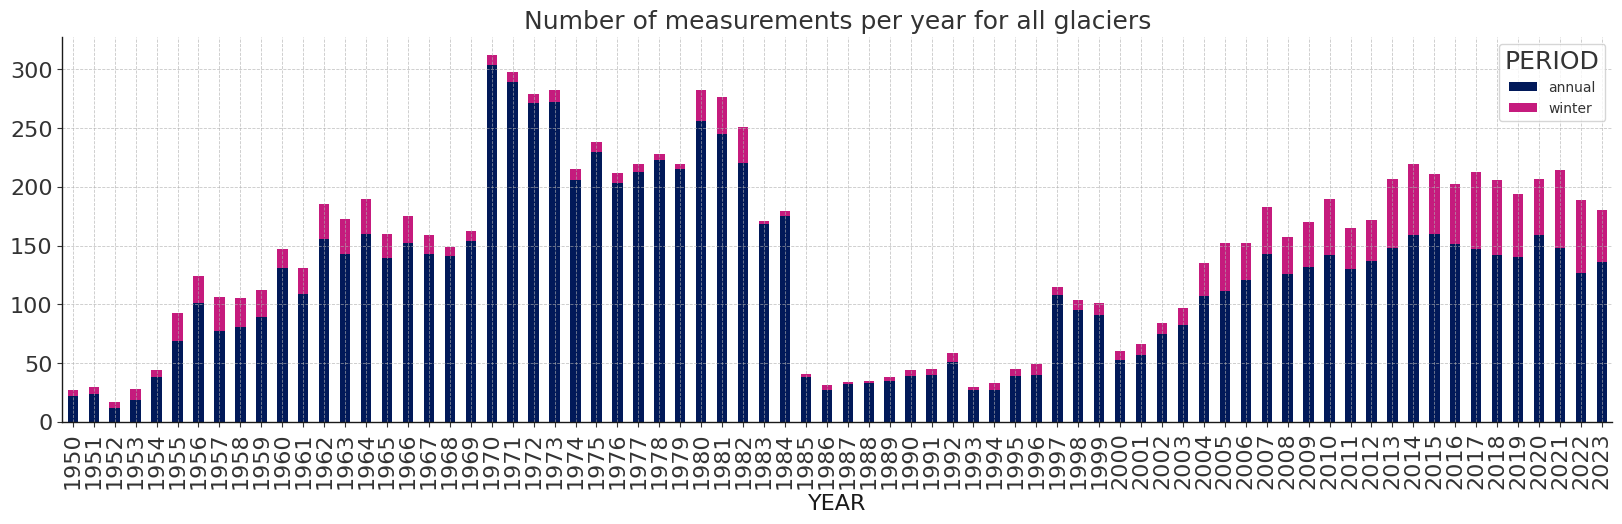

In [7]:
df_close_raw = df_annual_raw.copy()
files_stakes = [
    f for f in os.listdir(path_PMB_GLAMOS_csv_w_clean) if '_winter_close' in f
]
for file in files_stakes:
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]
    df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w_clean + file,
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0')

    df_close_raw = pd.concat([df_close_raw, df_winter])
df_close_raw.reset_index(drop=True, inplace=True)

# Correct issues with winter dates:
df_close_raw = CleanWinterDates(df_close_raw)

print('Number of winter and annual samples:', len(df_close_raw))
print('Number of winter samples:',
      len(df_close_raw[df_close_raw.PERIOD == 'winter']))
print('Number of annual samples:',
      len(df_close_raw[df_close_raw.PERIOD == 'annual']))

# download all stakes coordinates:
# df_close_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
#             'PERIOD']].to_csv(path_PMB_GLAMOS_csv + 'coordinates_all.csv')

# Save all stakes:
df_close_raw.to_csv(path_PMB_GLAMOS_csv + 'df_close_raw.csv')

# Plot:
# Number of measurements per year:
df_close_raw.groupby(['YEAR', 'PERIOD'
                      ]).size().unstack().plot(kind='bar',
                                               stacked=True,
                                               figsize=(20, 5),
                                               color=[color_xgb, color_tim])
plt.title('Number of measurements per year for all glaciers')

Number of winter and annual samples: 37407
Number of winter samples: 28202
Number of annual samples: 9205


Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

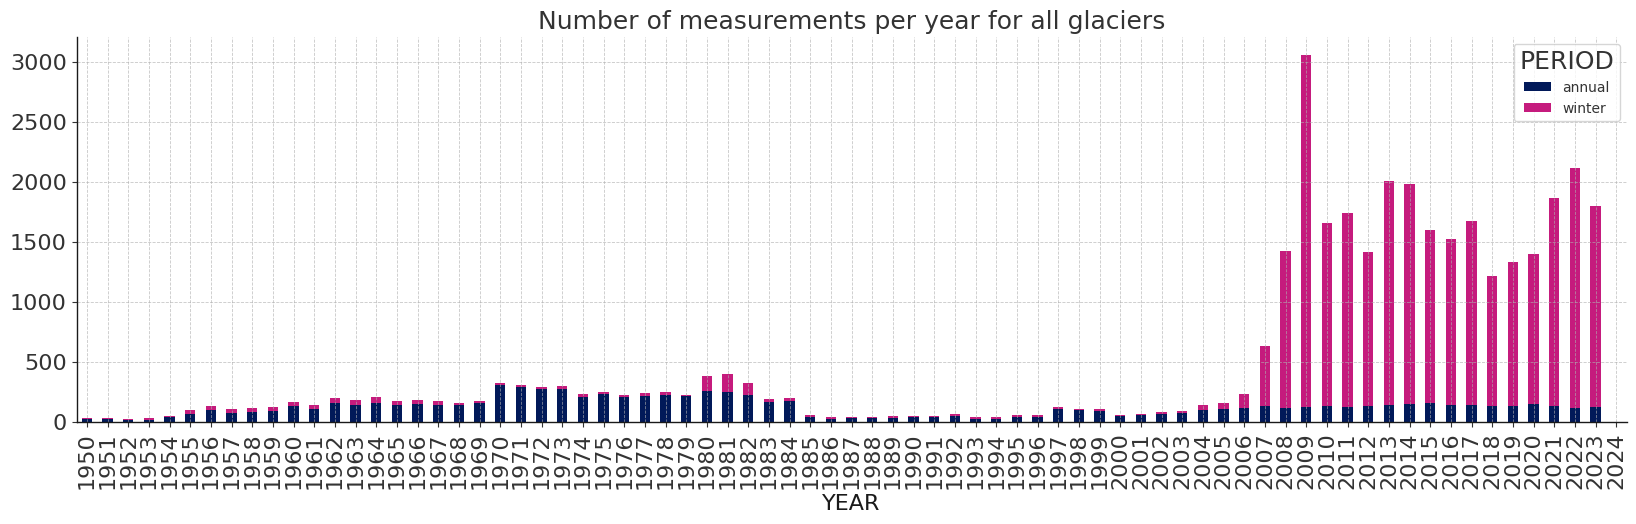

In [8]:
df_all_raw = df_annual_raw.copy()
files_stakes = [
    f for f in os.listdir(path_PMB_GLAMOS_csv_w_clean) if '_winter_all' in f
]
for file in files_stakes:
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]
    df_winter = pd.read_csv(path_PMB_GLAMOS_csv_w_clean + file,
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0')

    df_all_raw = pd.concat([df_all_raw, df_winter])
df_all_raw.reset_index(drop=True, inplace=True)
# Correct issues with winter dates:
df_all_raw = CleanWinterDates(df_all_raw)

print('Number of winter and annual samples:', len(df_all_raw))
print('Number of winter samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'winter']))
print('Number of annual samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'annual']))

# Save all stakes:
# remove Pers glacier (as is part of Morteratsch ensemble)
df_all_raw = df_all_raw[df_all_raw.GLACIER != 'pers']
df_all_raw.to_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv')

# download all stakes coordinates:
df_all_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
            'PERIOD']].to_csv('coordinates_all.csv')

# Plot:
# Number of measurements per year:
df_all_raw.groupby(['YEAR', 'PERIOD'
                    ]).size().unstack().plot(kind='bar',
                                             stacked=True,
                                             figsize=(20, 5),
                                             color=[color_xgb, color_tim])
plt.title('Number of measurements per year for all glaciers')

## 3. Add RGIs Ids:

In [9]:
DF_TYPE = 'all' # or 'all'
if DF_TYPE == 'close':
    # take only winter and annual stakes that are close to each other:
    df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_close_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1').drop(columns='Unnamed: 0')
    
else:
    # take all winter and annual stakes (lots of snow probes)
    df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1').drop(columns='Unnamed: 0')

# Keep relevant WGMS columns:
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]

# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection with shapefiles:
df_pmb = mbm.data_processing.utils.get_rgi(data=df_pmb,
                                           glacier_outlines=glacier_outline)

# Add RGIs without intersections (by finding the closest polygon):
# for points where polygon intersection is NaN (about a 1000)
no_match_df = df_pmb[df_pmb.RGIId.isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)
for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi


  0%|          | 0/2578 [00:00<?, ?it/s]

In [10]:
# Look at identified RGIs per glacier:
rgiids6 = df_pmb[['GLACIER',
                  'RGIId']].sort_values(by='GLACIER').drop_duplicates()
print('RGIs before pre-processing:')
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
rgis

RGIs before pre-processing:


{'adler': ['RGI60-11.02764', 'RGI60-11.02773'],
 'albigna': ['RGI60-11.02285', 'RGI60-11.02299', 'RGI60-11.02282'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704', 'RGI60-11.02770'],
 'basodino': ['RGI60-11.01987', 'RGI60-11.01592'],
 'blauschnee': ['RGI60-11.00638'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962', 'RGI60-11.02001'],
 'damma': ['RGI60-11.01246', 'RGI60-11.01234'],
 'diavolezza': ['RGI60-11.02013'],
 'findelen': ['RGI60-11.02773',
  'RGI60-11.02825',
  'RGI60-11.02674',
  'RGI60-11.02764'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876', 'RGI60-11.01961', 'RGI60-11.02441'],
 'hohlaub': ['RGI60-11.02679', 'RGI60-11.02674'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918', 'RGI60-11.00915'],
 'morteratsch': ['RGI60-11.01946

In [11]:
# Manual pre-processing and removal of errors:
df_pmb_clean = df_pmb.copy()
# reset index:
df_pmb_clean.reset_index(drop=True, inplace=True)

# Albigna: different rgis, remove stakes that are for two neighbouring glaciers:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'albigna')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02285')].index,
    inplace=True)

# Adler: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'adler')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02764')].index,
    inplace=True)

# Allalin: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'allalin')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02704')].index,
    inplace=True)

# Badodino: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'basodino')
                 & (df_pmb_clean.RGIId != 'RGI60-11.01987')].index,
    inplace=True)

# Blauschnee, not in any RGI v6 outline:
df_pmb_clean = df_pmb_clean[df_pmb_clean.GLACIER != 'blauschnee']

# Corvatsch: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'corvatsch')
                 & (df_pmb_clean.RGIId != 'RGI60-11.01962')].index,
    inplace=True)

# Damma: snow probes outside of rgi v6 outline:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'damma')
                 & (df_pmb_clean.RGIId != 'RGI60-11.01246')].index,
    inplace=True)

# Findelen: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'findelen')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02773')].index,
    inplace=True)

# hohlaub: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'hohlaub')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02679')].index,
    inplace=True)
# Gries: weird outlier coordinate
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'gries')
                             & (df_pmb_clean.RGIId != 'RGI60-11.01876')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Limmern: three stakes on neighbouring glacier
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'limmern')
                             & (df_pmb_clean.RGIId != 'RGI60-11.00918')].index
df_pmb_clean.drop(index_outlier, inplace=True)

# Offental: on no RGI v6 outline
df_pmb_clean = df_pmb_clean[df_pmb_clean.GLACIER != 'ofental']

# Orny: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'orny')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.02775'

# Otemma: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'otemma')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02801')].index,
    inplace=True)

# Plattalva: change to correct RGIId
index_outlier = df_pmb_clean[(df_pmb_clean.GLACIER == 'plattalva')].index
for i in index_outlier:
    df_pmb_clean.at[i, 'RGIId'] = 'RGI60-11.00892'

# Plainemorte: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'plainemorte')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02072')].index,
    inplace=True)

# Rhone outliers outside of RGI:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'rhone')
                 & (df_pmb_clean.RGIId != 'RGI60-11.01238')].index,
    inplace=True)

# Sanktanna: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'sanktanna')
                 & (df_pmb_clean.RGIId != 'RGI60-11.01367')].index,
    inplace=True)

# Sexrouge: snow probes on neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'sexrouge')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02244')].index,
    inplace=True)

# Silvretta: remove the stake that is on the neighbouring glacier:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'silvretta')
                 & (df_pmb_clean.RGIId != 'RGI60-11.00804')].index,
    inplace=True)

# tsanfleuron:
df_pmb_clean.drop(
    df_pmb_clean[(df_pmb_clean.GLACIER == 'tsanfleuron')
                 & (df_pmb_clean.RGIId != 'RGI60-11.02249')].index,
    inplace=True)
# Unteraar: Remove
df_pmb_clean = df_pmb_clean[df_pmb_clean.GLACIER != 'unteraar']

# Look at identified RGIs per glacier:
rgiids6 = df_pmb_clean[['GLACIER',
                        'RGIId']].sort_values(by='GLACIER').drop_duplicates()
rgis = {}
for gl in rgiids6.GLACIER.unique():
    rgis[gl] = list(rgiids6[rgiids6.GLACIER == gl].RGIId)
print('RGIs after pre-processing (should be one per glacier):')
rgis

RGIs after pre-processing (should be one per glacier):


{'adler': ['RGI60-11.02764'],
 'albigna': ['RGI60-11.02285'],
 'aletsch': ['RGI60-11.01450'],
 'allalin': ['RGI60-11.02704'],
 'basodino': ['RGI60-11.01987'],
 'cantun': ['RGI60-11.02268'],
 'chessjen': ['RGI60-11.02674'],
 'claridenL': ['RGI60-11.00817'],
 'claridenU': ['RGI60-11.00843'],
 'corbassiere': ['RGI60-11.02766'],
 'corvatsch': ['RGI60-11.01962'],
 'damma': ['RGI60-11.01246'],
 'diavolezza': ['RGI60-11.02013'],
 'findelen': ['RGI60-11.02773'],
 'forno': ['RGI60-11.02245'],
 'gietro': ['RGI60-11.02774'],
 'gorner': ['RGI60-11.02822'],
 'gries': ['RGI60-11.01876'],
 'hohlaub': ['RGI60-11.02679'],
 'joeri': ['RGI60-11.01063'],
 'limmern': ['RGI60-11.00918'],
 'morteratsch': ['RGI60-11.01946'],
 'murtel': ['RGI60-11.02024'],
 'oberaar': ['RGI60-11.01509'],
 'otemma': ['RGI60-11.02801'],
 'pizol': ['RGI60-11.00638'],
 'plainemorte': ['RGI60-11.02072'],
 'plattalva': ['RGI60-11.00892'],
 'rhone': ['RGI60-11.01238'],
 'sanktanna': ['RGI60-11.01367'],
 'sardona': ['RGI60-11.00689'],

## 5. Cut from 1951:

Number of winter and annual samples: 36267
Number of annual samples: 8799
Number of winter samples: 27468


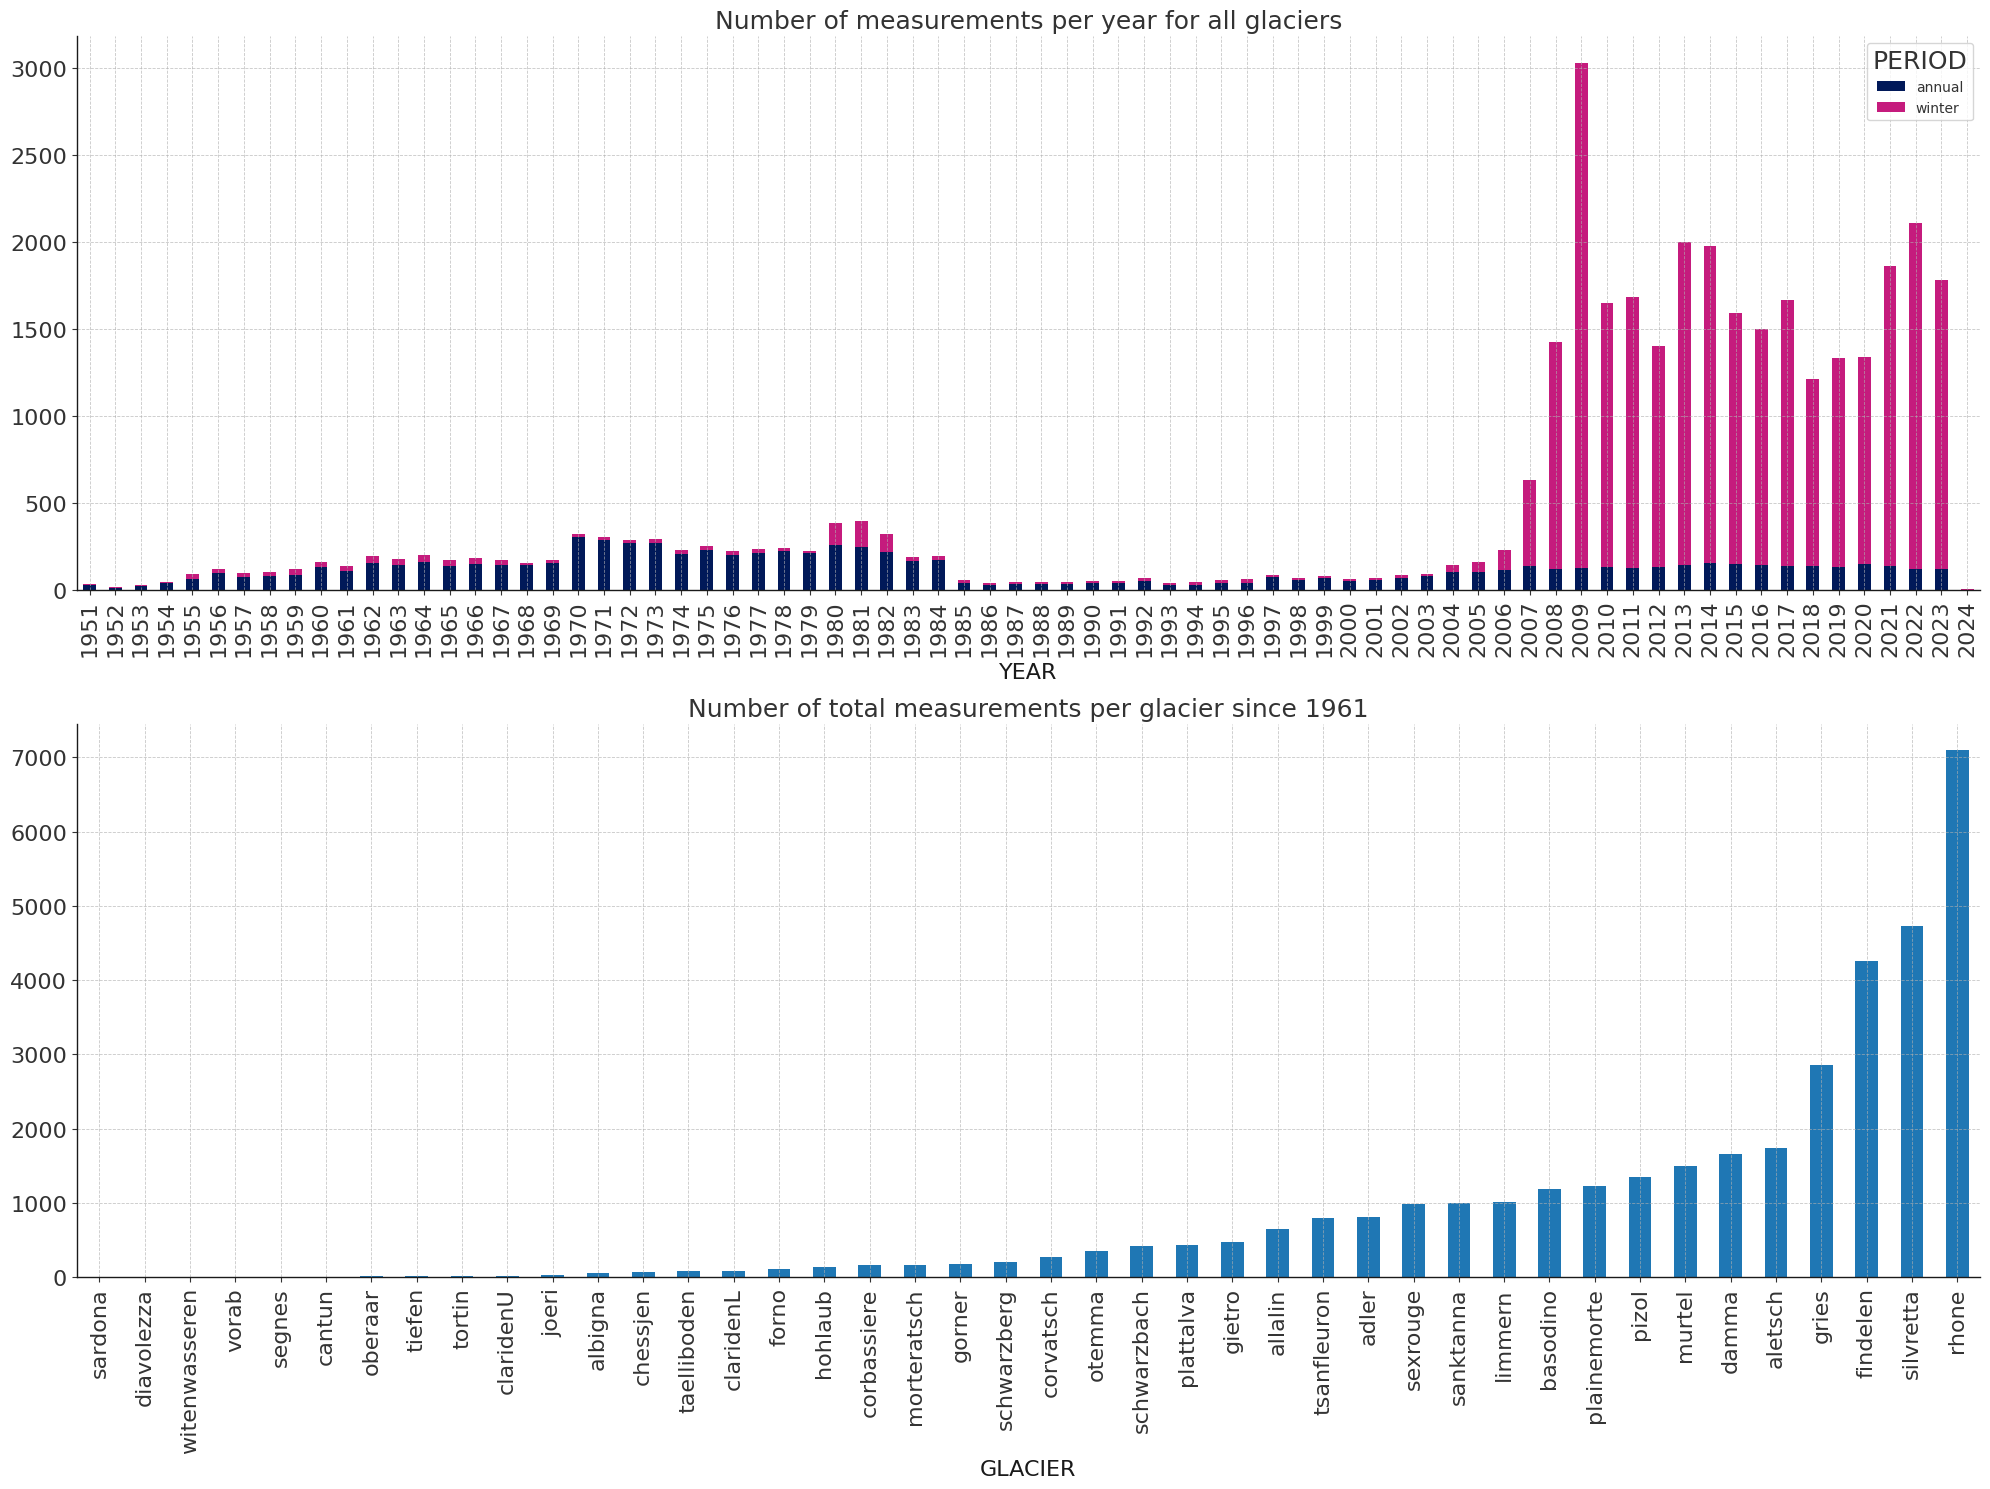

In [12]:
# Filter to start of MS data (1961) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])
print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR', 'PERIOD'
                    ]).size().unstack().plot(kind='bar',
                                             stacked=True,
                                             color=[color_xgb, color_tim],
                                             ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1961')
plt.tight_layout()

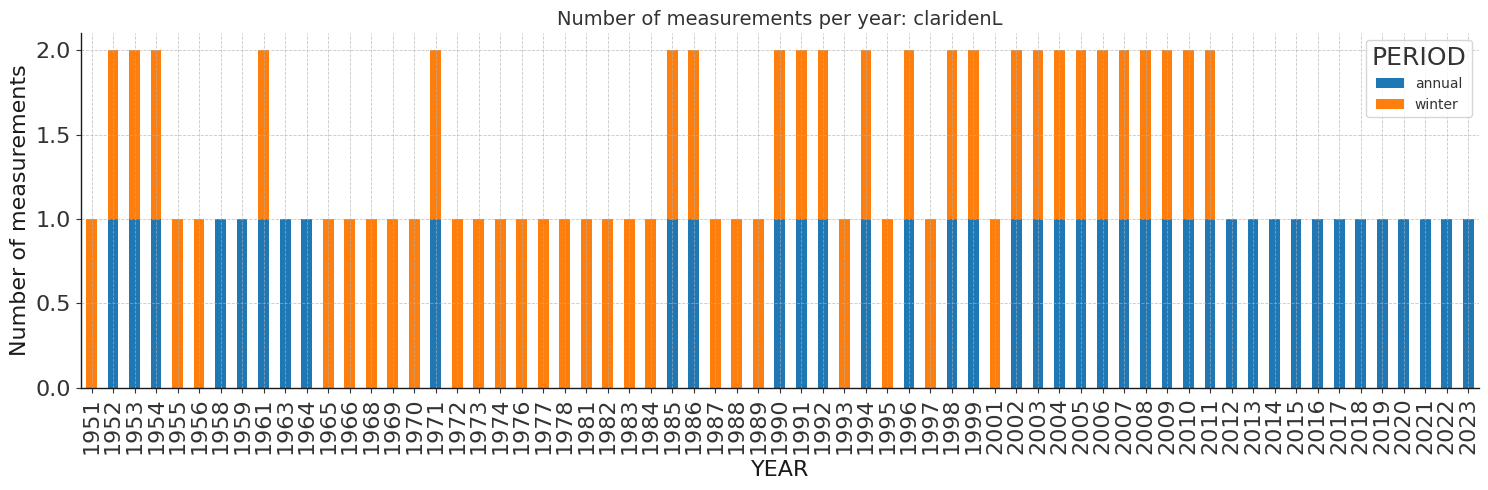

In [13]:
# Plot number of measurements per year
# Number of measurements per glacier per year:
glacierName = 'claridenL'
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
num_gl_yr = df_pmb_50s[df_pmb_50s.GLACIER == glacierName].groupby(
    ['YEAR', 'PERIOD']).size().unstack().reset_index()
num_gl_yr.plot(x='YEAR',
               kind='bar',
               stacked=True,
               ax=ax,
               title=f'{glacierName}')
ax.set_ylabel('Number of measurements')
ax.set_title(f'Number of measurements per year: {glacierName}', fontsize=14)
plt.tight_layout()

### 5.1. Merge stakes that are close: 


glacier:   0%|          | 0/42 [00:00<?, ?it/s]

----------------
 adler :
----------------
Number of points dropped: 3
----------------
 albigna :
----------------
Number of points dropped: 1
----------------
 aletsch :
----------------
Number of points dropped: 265
----------------
 allalin :
----------------
Number of points dropped: 32
----------------
 basodino :
----------------
Number of points dropped: 2
----------------
 cantun :
----------------
Number of points dropped: 0
----------------
 chessjen :
----------------
Number of points dropped: 43
----------------
 claridenL :
----------------
Number of points dropped: 0
----------------
 claridenU :
----------------
Number of points dropped: 0
----------------
 corbassiere :
----------------
Number of points dropped: 0
----------------
 corvatsch :
----------------
Number of points dropped: 1
----------------
 damma :
----------------
Number of points dropped: 233
----------------
 diavolezza :
----------------
Number of points dropped: 0
----------------
 findelen :
------

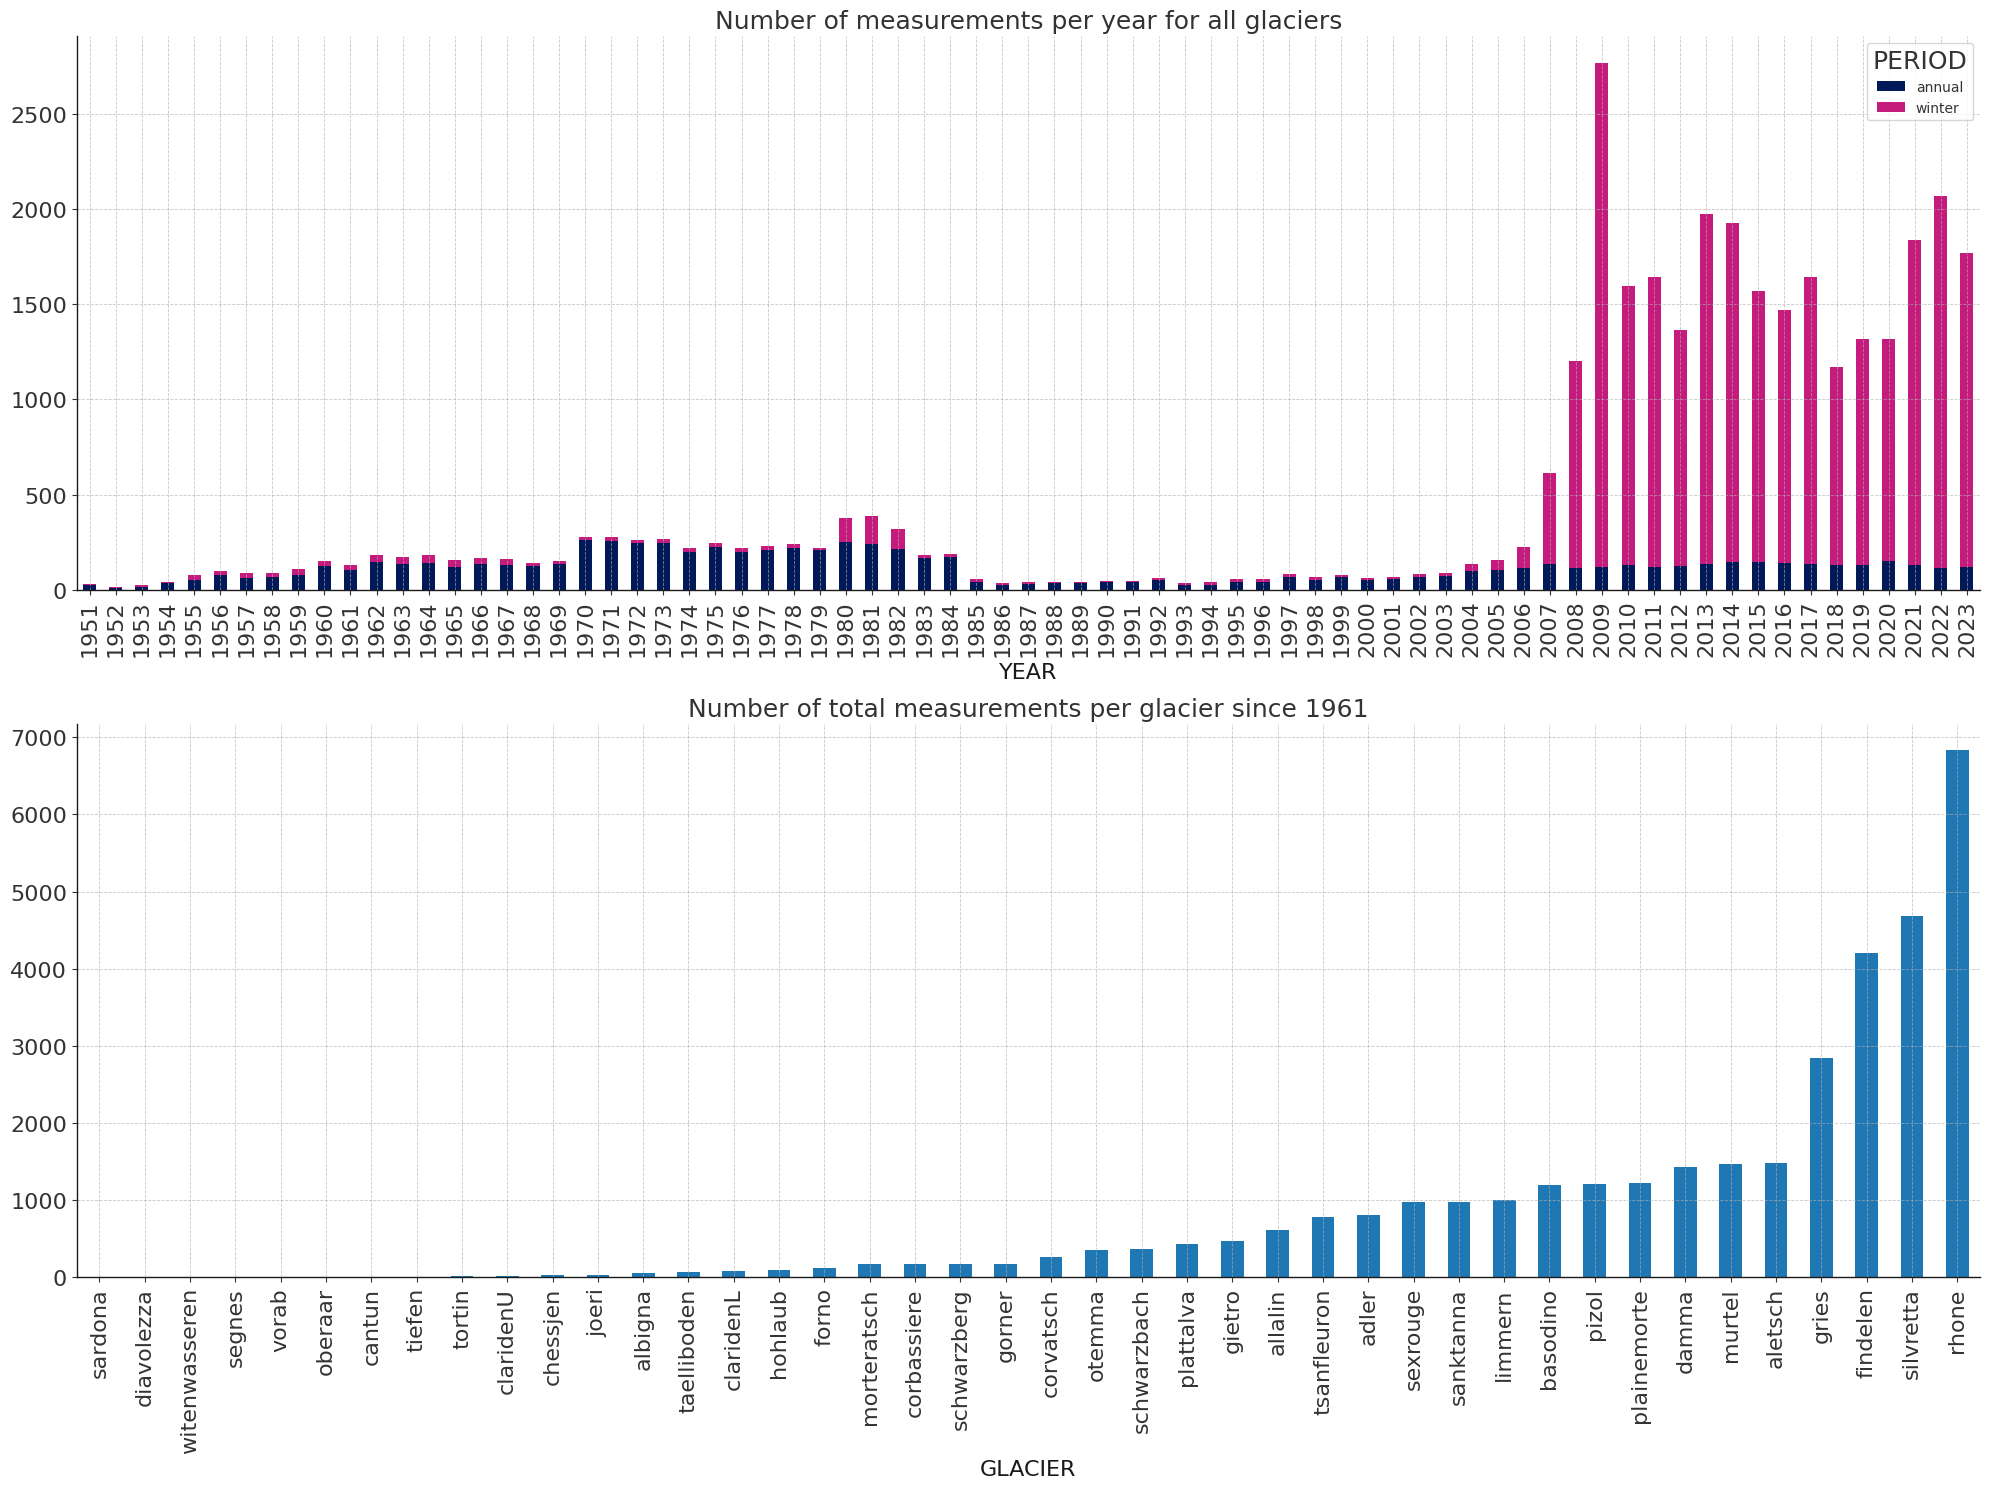

In [14]:
# clean df_pmb_50s
# Group similar stakes:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='glacier', position=0):
    print('----------------\n', gl, ':\n----------------')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

# Change from mm w.e. to m w.e.
df_pmb_50s_clean['POINT_BALANCE'] = df_pmb_50s_clean['POINT_BALANCE'] / 1000

# save to csv:
df_pmb_50s_clean.drop(['x', 'y', 'point'], axis=1).to_csv(
    path_PMB_GLAMOS_csv + f'df_pmb_50s_clean_all.csv', index=False)

# save coordinates:
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON', 'PERIOD'
                  ]].to_csv(path_PMB_GLAMOS_csv + f'coordinate_50s_clean_all.csv')

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_xgb, color_tim], ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1961')
plt.tight_layout()

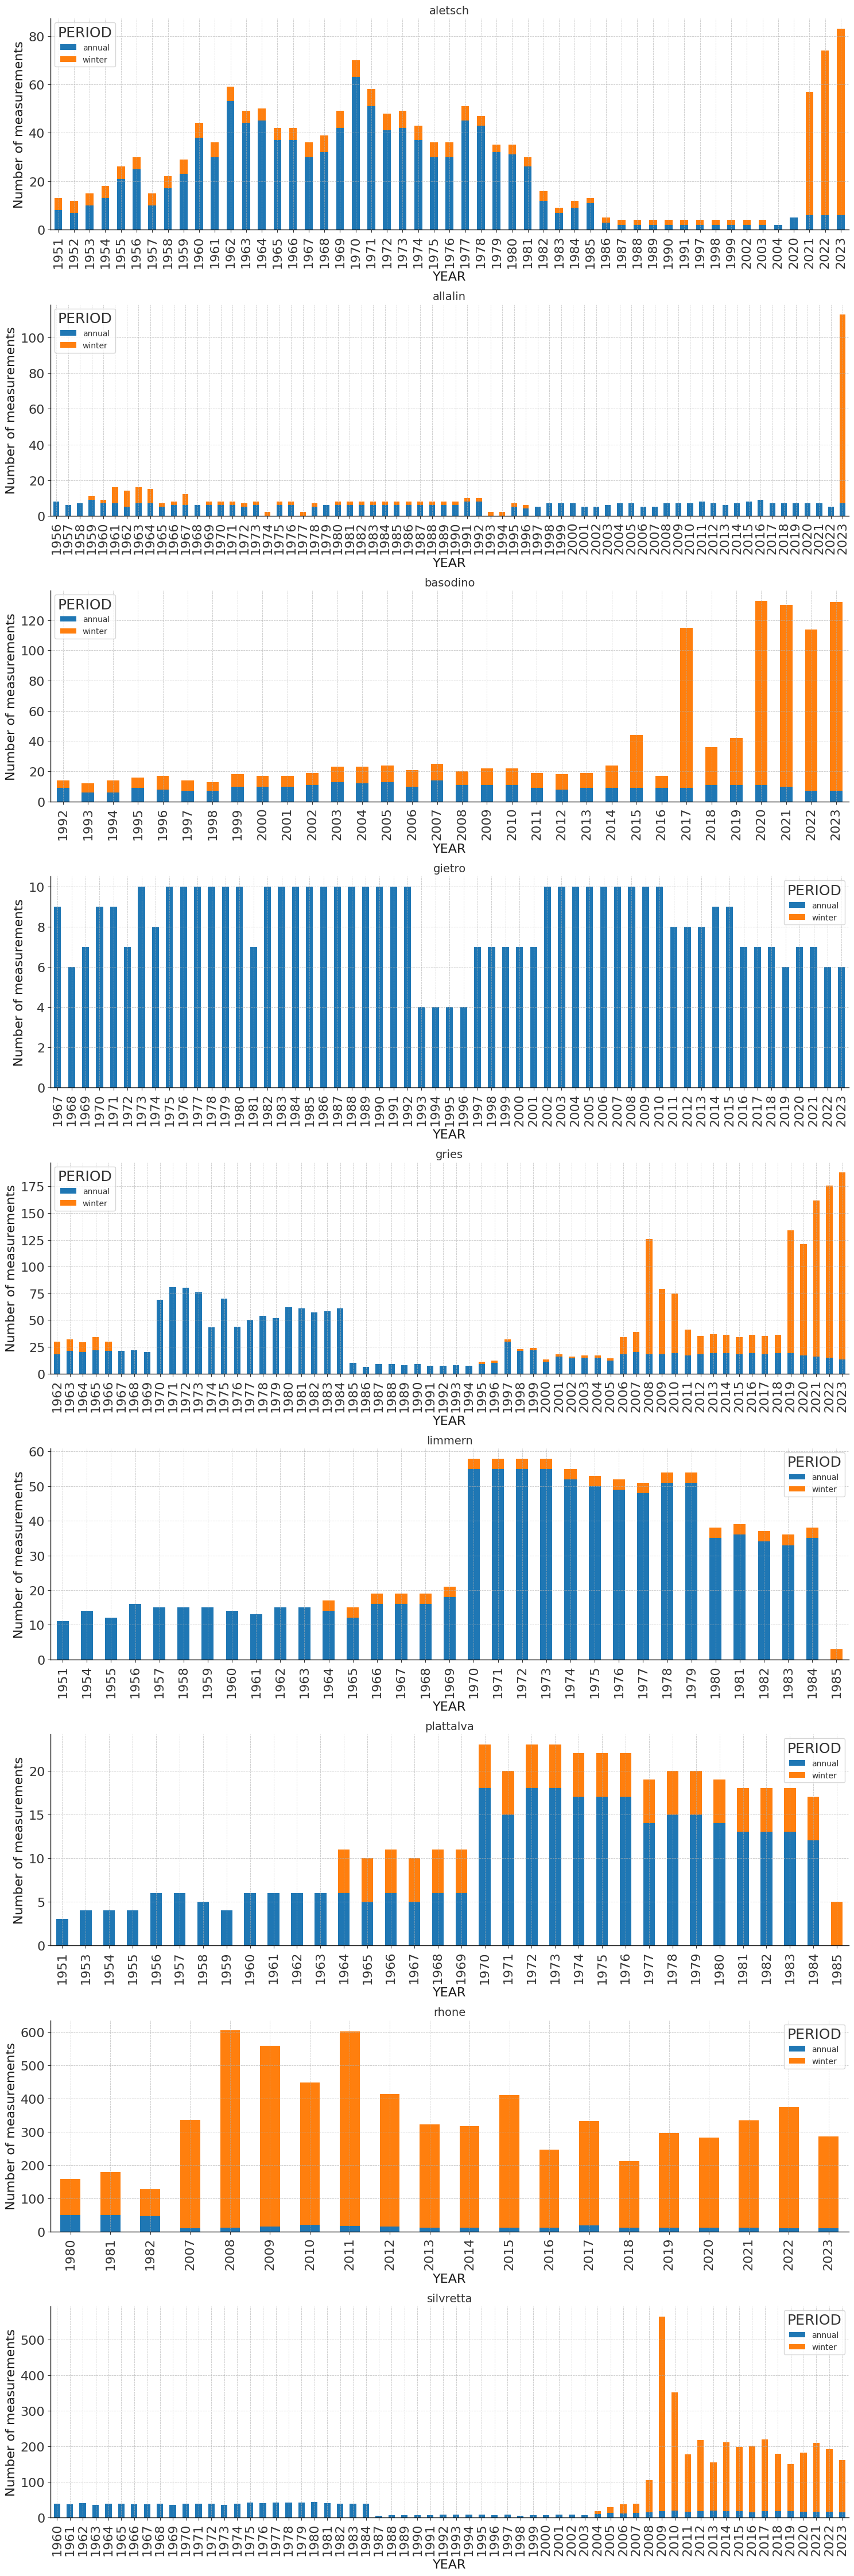

In [15]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title(gl, fontsize=14)
plt.tight_layout()

In [16]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

Number of glaciers: 42


['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'cantun',
 'chessjen',
 'claridenL',
 'claridenU',
 'corbassiere',
 'corvatsch',
 'damma',
 'diavolezza',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'sardona',
 'schwarzbach',
 'schwarzberg',
 'segnes',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tiefen',
 'tortin',
 'tsanfleuron',
 'vorab',
 'witenwasseren']

## Add topographical information from OGGM:

Number of winter and annual samples: 33405
Number of annual samples: 8355
Number of winter samples: 25050


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,288.55896,20.064414,3018.2
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,256.13032,11.781917,3077.2


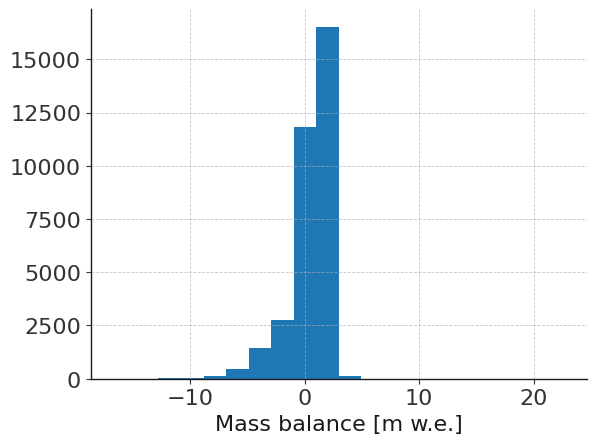

In [17]:
# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

# remove pers
df_pmb_topo = df_pmb_topo[df_pmb_topo.GLACIER != 'pers']

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')
df_pmb_topo.head(2)

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

glaciers:   0%|          | 0/33 [00:00<?, ?it/s]

Text(0.5, 0, 'Mass balance [m w.e.]')

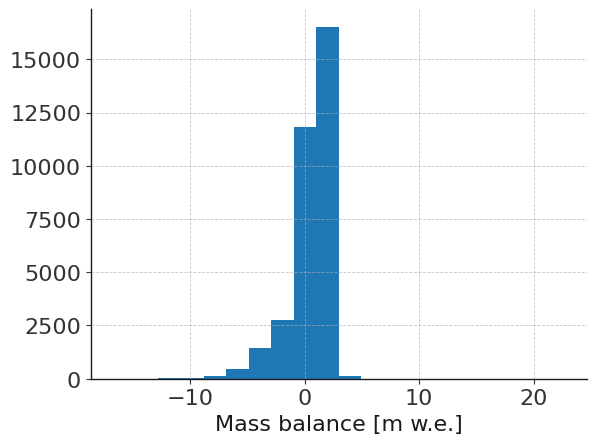

In [18]:
for glacierName in tqdm(df_pmb_topo.GLACIER.unique(), desc='glaciers'):
    gl_data = df_pmb_topo[df_pmb_topo.GLACIER == glacierName]
    stakeIDS = gl_data.groupby('POINT_ID')[[
        'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'
    ]].mean()
    stakeIDS.reset_index(inplace=True)
    # Change the ID according to elevation
    new_ids = stakeIDS[['POINT_ID',
                        'POINT_ELEVATION']].sort_values(by='POINT_ELEVATION')
    new_ids['POINT_ID_new'] = [
        f'{glacierName}_{i}' for i in range(len(new_ids))
    ]
    for i, row in new_ids.iterrows():
        df_pmb_topo.loc[(df_pmb_topo.GLACIER == glacierName) &
                        (df_pmb_topo.POINT_ID == row.POINT_ID),
                        'POINT_ID'] = row.POINT_ID_new
# Save to csv:
df_pmb_topo.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv', index=False)

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')


## Glacier wide MB:

In [19]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'obs' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
RUN = False
if RUN:
    emptyfolder(path_SMB_GLAMOS_csv + 'obs/')
    for file in glamosfiles_smb:
        fileName = re.split('.dat', file)[0]
        processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                            path_SMB_GLAMOS_csv + 'obs/')

# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

Examples of index stake raw files:
 ['pizol_obs.dat', 'clariden_obs.dat', 'schwarzberg_obs.dat', 'gries_obs.dat', 'hohlaub_obs.dat']


,# MB_ID,date0,date_f,date_s,date1,Winter Balance,Annual Balance,ELA,AAR,Area,...,A_eb_15,A_eb_16,A_eb_17,A_eb_18,A_eb_19,A_eb_20,A_eb_21,A_eb_22,A_eb_23,A_eb_24
0,0,19141001,928,430,19150930,1341,217,2825,70,91.815,...,7.385,8.18,7.28,8.21,7.3175,5.06,2.4225,0.9975,0.25,0.0625
1,0,19151001,928,430,19160930,1450,771,2715,76,91.815,...,7.385,8.18,7.28,8.21,7.3175,5.06,2.4225,0.9975,0.25,0.0625


In [20]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'fix' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
RUN = False
if RUN:
    emptyfolder(path_SMB_GLAMOS_csv + 'fix/')
    for file in glamosfiles_smb:
        fileName = re.split('.dat', file)[0]
        processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                            path_SMB_GLAMOS_csv + 'fix/')

# Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

Examples of index stake raw files:
 ['pizol_fix.dat', 'gietro_fix.dat', 'corbassiere_fix.dat', 'aletsch_fix.dat', 'oberaar_fix.dat']


,# MB_ID,date0,date_f,date_s,date1,Winter Balance,Annual Balance,ELA,AAR,Area,...,A_eb_15,A_eb_16,A_eb_17,A_eb_18,A_eb_19,A_eb_20,A_eb_21,A_eb_22,A_eb_23,A_eb_24
0,0,19141001,1001,430,19150930,1339,217,2825,70,91.815,...,7.385,8.18,7.28,8.21,7.3175,5.06,2.4225,0.9975,0.25,0.0625
1,0,19151001,1001,430,19160930,1387,771,2715,76,91.815,...,7.385,8.18,7.28,8.21,7.3175,5.06,2.4225,0.9975,0.25,0.0625


## Potential incoming clear sky solar radiation:

Pre-process glamos data of Potential incoming clear sky solar radiation. One per day grid per glacier for one year only, depends on the glacier.

In [21]:
glDirect = os.listdir(path_direct)
glDirect.sort()  # Glaciers with data

# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

print('Number of glacier with clear sky radiation data:', len(glDirect))
glDirect

Number of glacier with clear sky radiation data: 33


['albigna',
 'aletsch',
 'allalin',
 'arolla',
 'basodino',
 'clariden',
 'corbassiere',
 'corvatsch',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pers',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'schwarzbach',
 'schwarzberg',
 'sexrouge',
 'silvretta',
 'stanna',
 'taelliboden',
 'tortin',
 'tsanfleuron']

In [22]:
from calendar import monthrange

empty = False
if empty:
    emptyfolder(path_direct_save)
else:
    glProcessed = [
        re.search(r"xr_direct_(.*)\.nc", f).group(1)
        for f in os.listdir(path_direct_save)
    ]
    glDirect = list(set(glDirect) - set(glProcessed))

for glacierName in tqdm(glDirect, desc='glaciers', position=0):
    print(glacierName)
    grid = os.listdir(path_direct + glacierName)
    grid_year = int(re.findall(r'\d+', grid[0])[0])
    daily_grids = os.listdir(path_direct + glacierName + '/' + grid[0])
    # Sort by day number from 001 to 365
    daily_grids.sort()
    grids = []
    for fileName in daily_grids:
        if 'grid' not in fileName:
            continue

        # Load daily grid file
        file_path = path_direct + glacierName + '/' + grid[0] + '/' + fileName
        metadata, grid_data = load_grid_file(file_path)
        grids.append(grid_data)
    # Take mean over all days
    # mean_grid = np.mean(np.stack(grids, axis=0), axis=0)

    # Take monthly means:
    monthly_grids = []
    for i in range(12):
        num_days_month = monthrange(grid_year, i + 1)[1]
        monthly_grids.append(
            np.mean(np.stack(grids[i * num_days_month:(i + 1) *
                                   num_days_month],
                             axis=0),
                    axis=0))

    monthly_grids = np.array(monthly_grids)
    num_months = monthly_grids.shape[0]

    # Convert to xarray (CH coordinates)
    data_array = convert_to_xarray(monthly_grids, metadata, num_months)

    # Convert to WGS84 (lat/lon) coordinates
    data_array_transf = transform_xarray_coords_lv03_to_wgs84(data_array)

    # Save xarray
    if glacierName == 'findelen':
        data_array_transf.to_netcdf(path_direct_save +
                                    f'xr_direct_{glacierName}.nc')
        data_array_transf.to_netcdf(path_direct_save + f'xr_direct_adler.nc')
    elif glacierName == 'stanna':
        data_array_transf.to_netcdf(path_direct_save +
                                    f'xr_direct_sanktanna.nc')
    elif glacierName == 'clariden':
        data_array_transf.to_netcdf(path_direct_save +
                                    f'xr_direct_claridenL.nc')
        data_array_transf.to_netcdf(path_direct_save +
                                    f'xr_direct_claridenU.nc')
    else:
        data_array_transf.to_netcdf(path_direct_save +
                                    f'xr_direct_{glacierName}.nc')

glaciers:   0%|          | 0/2 [00:00<?, ?it/s]

clariden
stanna


In [23]:
# Number of processed glaciers:
print('Number of processed glaciers:', len(os.listdir(path_direct_save)))

Number of processed glaciers: 35


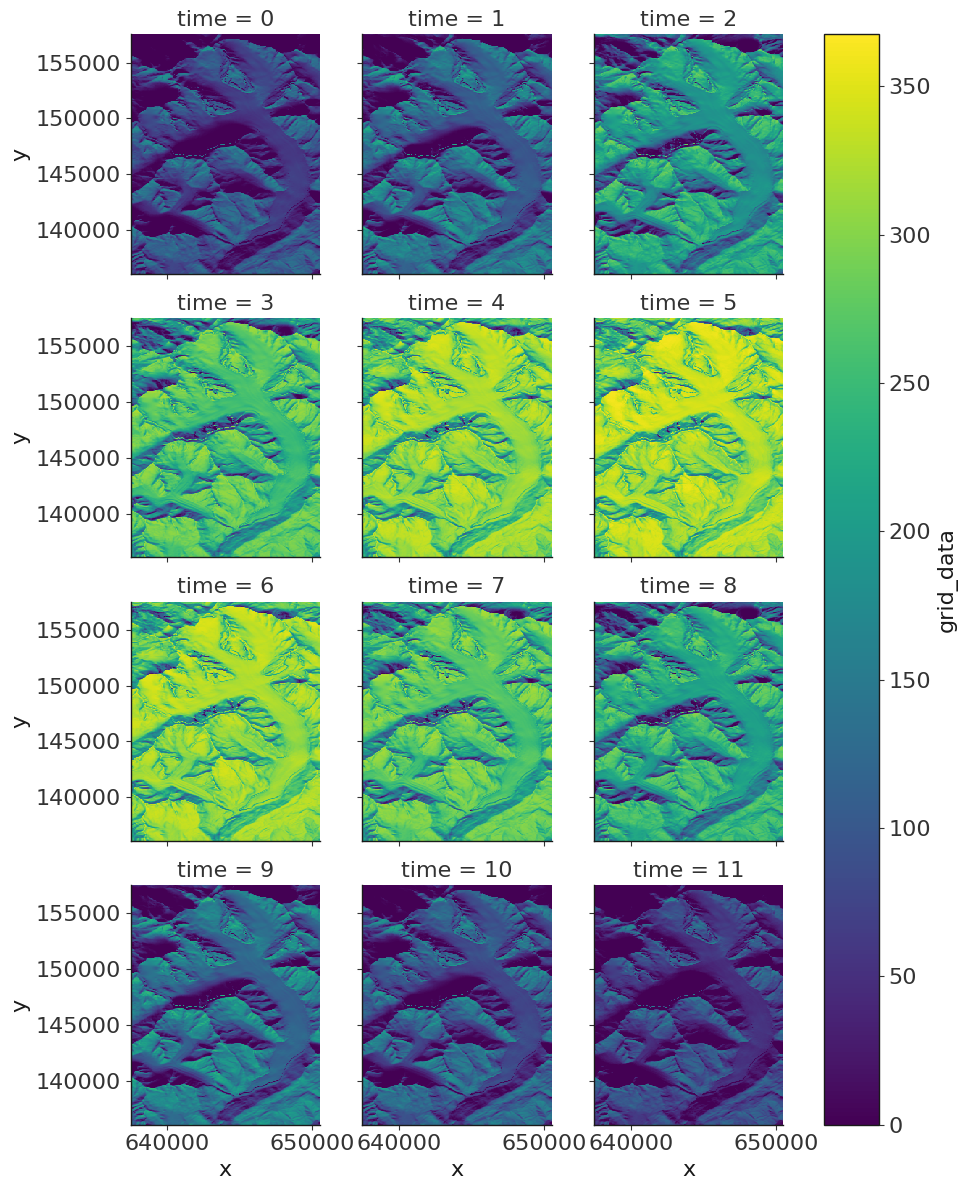

In [24]:
# read an plot one file
xr_file = xr.open_dataset(path_direct_save + 'xr_direct_aletsch.nc')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)

### Geodetic MB:

In [58]:
fileName = 'dV_DOI2024_allcomb.dat'

# Open and read the .dat file
with open(path_geodetic_MB+fileName, 'r') as file:
    lines = file.readlines()

# Extract the header and data
header_line = lines[0].strip()
column_names = re.split(r'\s{2,}', header_line)
print(column_names, len(column_names))

# Data starts after the header rows
data_lines = lines[2:]  # Skip the header and unit rows

# Prepare data for the DataFrame
data = []
for line in data_lines:
    # Split the line into fields and handle trailing comments
    fields = re.split(r'\s{2,}|\s(?=[^;]*$)', line.strip())
    if len(fields) > len(column_names):
        # merge last two columns
        fields = fields[:len(column_names) - 1] + [' '.join(fields[len(column_names) - 1:])]
    data.append(fields)

# Create the DataFrame
df = pd.DataFrame(data, columns=column_names)

# Save to csv
df.to_csv(path_geodetic_MB + 'dV_DOI2024_allcomb' + '.csv', index=False)

['SGI-ID', 'Source1', 'Source2', 'date_start', 'date_end', 'EDGEstart', 'Astart', 'EDGEend', 'A_end', 'dV', 'dh_mean', 'Bgeod', 'sigma', 'covered', 'rho_dv', 'Name'] 16
